In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil

# Define the paths
gdrive_train_path = '/content/drive/Othercomputers/My MacBook Pro/train'
gdrive_test_path = '/content/drive/Othercomputers/My MacBook Pro/test'
local_train_path = '/content/oct_train'
local_test_path = '/content/oct_test'

# Copy train and test data from Google Drive to local disk
if not os.path.exists(local_train_path):
    shutil.copytree(gdrive_train_path, local_train_path)
if not os.path.exists(local_test_path):
    shutil.copytree(gdrive_test_path, local_test_path)

# Verify the copied data
print("Local Training directory structure:")
!ls {local_train_path}

print("\nLocal Testing directory structure:")
!ls {local_test_path}

Local Training directory structure:
0  1

Local Testing directory structure:
0  1


In [4]:

!ls
!pwd

drive  oct_test  oct_train  sample_data
/content


In [53]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.data import AUTOTUNE
import numpy as np
import imgaug.augmenters as iaa
import tensorflow as tf




In [13]:
# Define custom augmentation function
def augment_images(images):
    aug = iaa.Sequential([
        iaa.GaussianBlur(sigma=(0.0, 3.0)),
        iaa.AdditiveGaussianNoise(scale=(10, 60))
    ])
    images_aug = aug(images=images)
    return images_aug

# Wrap the augmentation function for TensorFlow
def augment(images, labels):
    images = tf.numpy_function(augment_images, [images], tf.float32)
    return images, labels

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 64
image_size = (128, 128)

# Define paths
train_data_path = '/content/oct_train'
test_data_path = '/content/oct_test'

# Data Generators with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)  # 20% of the data will be used for validation
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Set as validation data
)

test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 9320 images belonging to 2 classes.
Found 2329 images belonging to 2 classes.
Found 2867 images belonging to 2 classes.


In [31]:
# Convert DirectoryIterators to tf.data.Dataset
def gen_to_tfdata(generator):
    def gen():
        for x, y in generator:
            yield x, y
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )

In [32]:
# Wrap the train generator to include custom augmentations
train_dataset = gen_to_tfdata(train_generator).map(augment, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = gen_to_tfdata(validation_generator).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = gen_to_tfdata(test_generator).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Define MobileNetV2 model with modified input size
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.5),
    Dense(1, activation='sigmoid', dtype='float32')  # Ensure final layer is float32
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
hist = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,  # Increased epochs for better learning
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
146/146 [==============================] - 88s 455ms/step - loss: 0.9746 - accuracy: 0.8489 - val_loss: 0.8902 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 2/5
146/146 [==============================] - 65s 451ms/step - loss: 0.8863 - accuracy: 0.8614 - val_loss: 0.8799 - val_accuracy: 0.8605 - lr: 1.0000e-04
Epoch 3/5
146/146 [==============================] - 65s 445ms/step - loss: 0.8504 - accuracy: 0.8617 - val_loss: 0.8158 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 4/5
146/146 [==============================] - 63s 437ms/step - loss: 0.8180 - accuracy: 0.8617 - val_loss: 0.7831 - val_accuracy: 0.8656 - lr: 1.0000e-04
Epoch 5/5
146/146 [==============================] - 61s 418ms/step - loss: 0.7880 - accuracy: 0.8617 - val_loss: 0.7652 - val_accuracy: 0.8579 - lr: 1.0000e-04


In [58]:
from tensorflow.keras.applications import VGG16

# Define VGG16 model with modified input size
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_vgg = Sequential([
    base_model_vgg,
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Reduced the number of units
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid', dtype='float32')  # Ensure final layer is float32
])

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
hist_vgg = model_vgg.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/20
146/146 [==============================] - 73s 470ms/step - loss: 0.9559 - accuracy: 0.5777 - val_loss: 0.8267 - val_accuracy: 0.7853 - lr: 1.0000e-04
Epoch 2/20
146/146 [==============================] - 69s 471ms/step - loss: 0.7648 - accuracy: 0.7008 - val_loss: 0.6425 - val_accuracy: 0.8429 - lr: 1.0000e-04
Epoch 3/20
146/146 [==============================] - 69s 470ms/step - loss: 0.6381 - accuracy: 0.7928 - val_loss: 0.7484 - val_accuracy: 0.8626 - lr: 1.0000e-04
Epoch 4/20
146/146 [==============================] - 69s 472ms/step - loss: 0.5467 - accuracy: 0.8443 - val_loss: 0.5240 - val_accuracy: 0.8605 - lr: 1.0000e-04
Epoch 5/20
146/146 [==============================] - 69s 470ms/step - loss: 0.4465 - accuracy: 0.8882 - val_loss: 0.6083 - val_accuracy: 0.8643 - lr: 1.0000e-04
Epoch 6/20
146/146 [==============================] - 69s 469ms/step - loss: 0.3820 - accuracy: 0.9131 - val_loss: 0.6007 - val_accuracy: 0.8669 - lr: 1.0000e-04
Epoch 7/20
146/146 [========

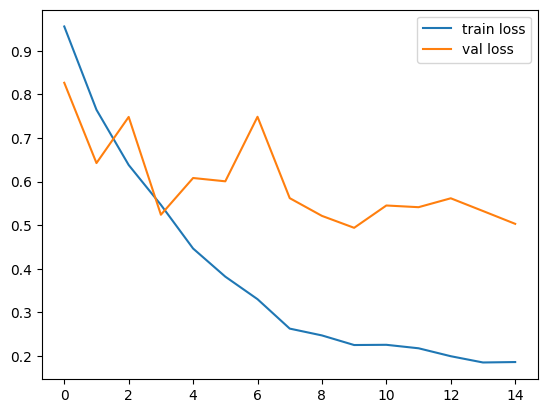

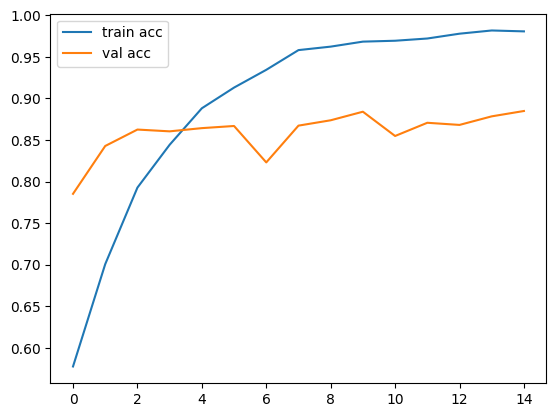

<Figure size 640x480 with 0 Axes>

In [59]:
# plot the loss
plt.plot(hist_vgg.history['loss'], label='train loss')
plt.plot(hist_vgg.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist_vgg.history['accuracy'], label='train acc')
plt.plot(hist_vgg.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('VGG_AccVal_acc')

In [49]:
# CM plot function

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_generator):
    test_generator.reset()
    Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    y_pred = np.round(Y_pred).astype(int).flatten()

    y_true = test_generator.classes[:len(y_pred)]

    # Ensure the lengths match
    print(f'Length of y_true: {len(y_true)}')
    print(f'Length of y_pred: {len(y_pred)}')

    # Calculate precision and recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

    # Classification report
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Class 0', 'Predicted Class 1'], yticklabels=['Actual Class 0', 'Actual Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Extracting individual values
    TN, FP, FN, TP = cm.ravel()
    print(f'True Positives (TP): {TP}')
    print(f'True Negatives (TN): {TN}')
    print(f'False Positives (FP): {FP}')
    print(f'False Negatives (FN): {FN}')

Evaluating VGG16:
44/44 [==============================] - 8s 167ms/step
Length of y_true: 2816
Length of y_pred: 2816
Precision: 0.8001514004542014
Recall: 0.9600363306085377
              precision    recall  f1-score   support

     Class 0       0.49      0.14      0.22       614
     Class 1       0.80      0.96      0.87      2202

    accuracy                           0.78      2816
   macro avg       0.65      0.55      0.55      2816
weighted avg       0.73      0.78      0.73      2816



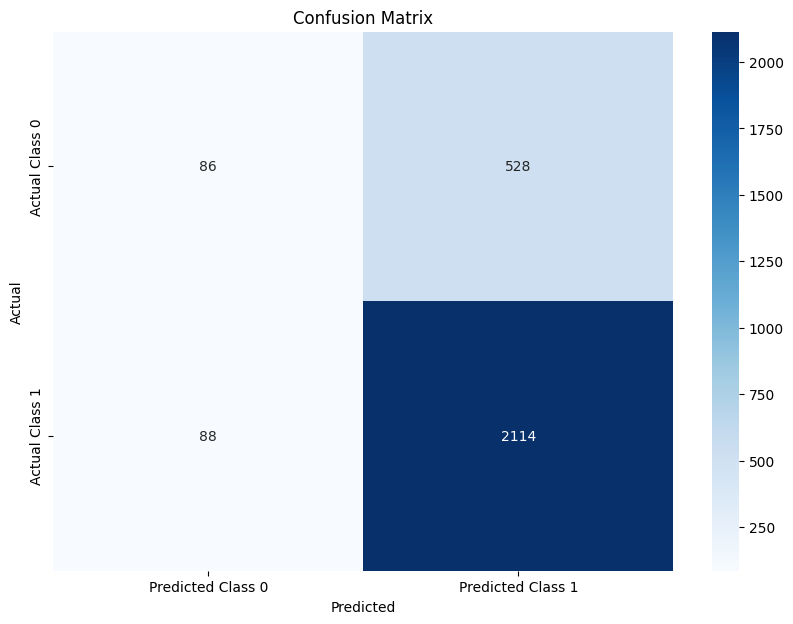

True Positives (TP): 2114
True Negatives (TN): 86
False Positives (FP): 528
False Negatives (FN): 88


In [60]:
# Evaluate VGG16 model
print("Evaluating VGG16:")
evaluate_model(model_vgg, test_generator)


In [68]:
model_vgg.save('/content/models/vgg16_model.h5')
model_vgg.save_weights('/content/models/vgg16_weights.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20
146/146 [==============================] - 70s 475ms/step - loss: 0.2432 - accuracy: 0.9685 - val_loss: 0.5389 - val_accuracy: 0.8751 - lr: 4.0000e-06
Epoch 2/20
146/146 [==============================] - 69s 471ms/step - loss: 0.2193 - accuracy: 0.9635 - val_loss: 0.5716 - val_accuracy: 0.8725 - lr: 4.0000e-06
Epoch 3/20
146/146 [==============================] - 69s 473ms/step - loss: 0.2123 - accuracy: 0.9648 - val_loss: 0.5321 - val_accuracy: 0.8836 - lr: 4.0000e-06
Epoch 4/20
146/146 [==============================] - 69s 471ms/step - loss: 0.2060 - accuracy: 0.9659 - val_loss: 0.5403 - val_accuracy: 0.8785 - lr: 4.0000e-06
Epoch 5/20
146/146 [==============================] - 69s 469ms/step - loss: 0.1981 - accuracy: 0.9732 - val_loss: 0.5613 - val_accuracy: 0.8763 - lr: 4.0000e-06
Epoch 6/20
146/146 [==============================] - 69s 472ms/step - loss: 0.2031 - accuracy: 0.9671 - val_loss: 0.5525 - val_accuracy: 0.8738 - lr: 4.0000e-06
Epoch 7/20
146/146 [========

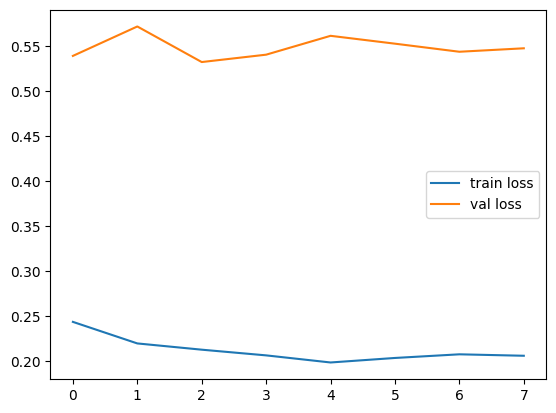

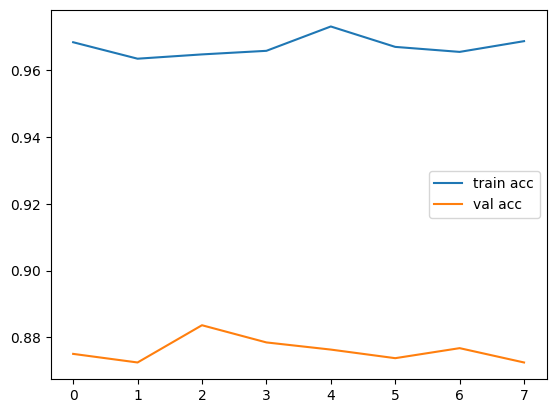

<Figure size 640x480 with 0 Axes>

In [71]:
# try with class weightes

from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

# Dictionary of class weights
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
hist_vgg_class_weight = model_vgg.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)
#not better

Evaluating Xception:
44/44 [==============================] - 7s 166ms/step
Length of y_true: 2816
Length of y_pred: 2816
Precision: 0.806774441878368
Recall: 0.9518619436875567
              precision    recall  f1-score   support

     Class 0       0.51      0.18      0.27       614
     Class 1       0.81      0.95      0.87      2202

    accuracy                           0.78      2816
   macro avg       0.66      0.57      0.57      2816
weighted avg       0.74      0.78      0.74      2816



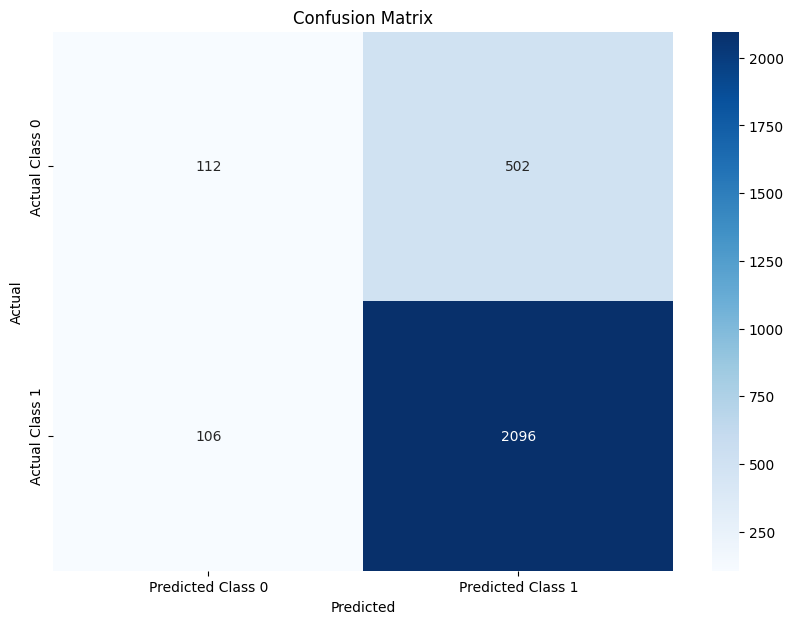

True Positives (TP): 2096
True Negatives (TN): 112
False Positives (FP): 502
False Negatives (FN): 106


In [75]:
# Evaluate Xception model
print("Evaluating Xception:")
evaluate_model(model_vgg, test_generator)

In [62]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Define Xception model
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_xception = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_xception.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist_xception = model_xception.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

Epoch 1/20
146/146 [==============================] - 92s 478ms/step - loss: 1.1338 - accuracy: 0.6590 - val_loss: 1.0817 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 2/20
146/146 [==============================] - 69s 471ms/step - loss: 0.7955 - accuracy: 0.8878 - val_loss: 1.0978 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 3/20
146/146 [==============================] - 69s 472ms/step - loss: 0.6645 - accuracy: 0.9319 - val_loss: 0.9118 - val_accuracy: 0.8235 - lr: 1.0000e-04
Epoch 4/20
146/146 [==============================] - 69s 474ms/step - loss: 0.6021 - accuracy: 0.9433 - val_loss: 0.9276 - val_accuracy: 0.8536 - lr: 1.0000e-04
Epoch 5/20
146/146 [==============================] - 69s 476ms/step - loss: 0.5167 - accuracy: 0.9629 - val_loss: 0.7169 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 6/20
146/146 [==============================] - 70s 477ms/step - loss: 0.4885 - accuracy: 0.9665 - val_loss: 0.7274 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 7/20
146/146 [========

In [ ]:
# Evaluate Xception model
print("Evaluating Xception:")
evaluate_model(model_xception, test_generator)

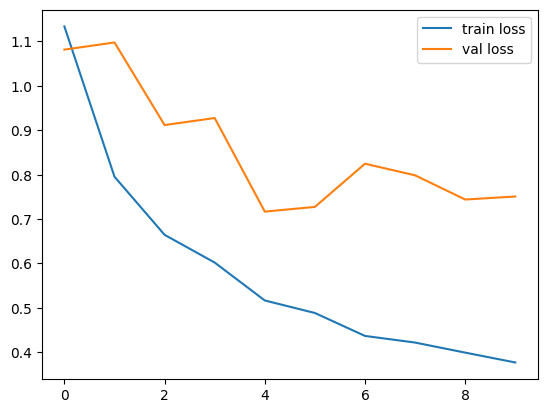

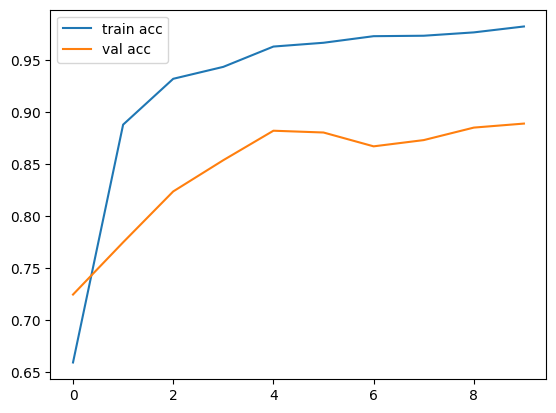

<Figure size 640x480 with 0 Axes>

In [63]:
# plot the loss
plt.plot(hist_xception.history['loss'], label='train loss')
plt.plot(hist_xception.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist_xception.history['accuracy'], label='train acc')
plt.plot(hist_xception.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Xcep_AccVal_acc')

In [66]:
# save the xception model
model_xception.save('/content/models/xception_model.h5')
# save the xecption model weights
model_xception.save_weights('/content/models/xception_weights.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluating Xception:
44/44 [==============================] - 7s 170ms/step
Length of y_true: 2816
Length of y_pred: 2816
Precision: 0.805249144161278
Recall: 0.9613987284287012
              precision    recall  f1-score   support

     Class 0       0.55      0.17      0.25       614
     Class 1       0.81      0.96      0.88      2202

    accuracy                           0.79      2816
   macro avg       0.68      0.56      0.57      2816
weighted avg       0.75      0.79      0.74      2816



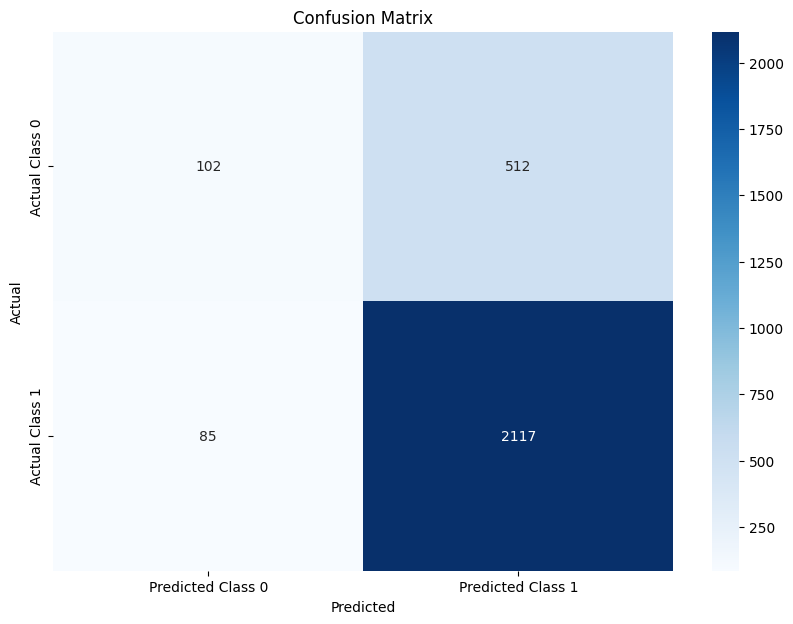

True Positives (TP): 2117
True Negatives (TN): 102
False Positives (FP): 512
False Negatives (FN): 85


In [67]:
# Evaluate Xception model
print("Evaluating Xception:")
evaluate_model(model_xception, test_generator)

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define a simpler CNN model
model_simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_simple_cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist_simple_cnn = model_simple_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/20
146/146 [==============================] - 71s 470ms/step - loss: 0.6976 - accuracy: 0.8499 - val_loss: 0.8527 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 2/20
146/146 [==============================] - 69s 470ms/step - loss: 0.6024 - accuracy: 0.8748 - val_loss: 1.8915 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 3/20
146/146 [==============================] - 68s 468ms/step - loss: 0.5586 - accuracy: 0.8882 - val_loss: 2.7622 - val_accuracy: 0.8617 - lr: 1.0000e-04
Epoch 4/20
146/146 [==============================] - 68s 469ms/step - loss: 0.5245 - accuracy: 0.8951 - val_loss: 2.2331 - val_accuracy: 0.8617 - lr: 2.0000e-05
Epoch 5/20
146/146 [==============================] - 68s 467ms/step - loss: 0.5005 - accuracy: 0.9001 - val_loss: 1.0976 - val_accuracy: 0.8626 - lr: 2.0000e-05
Epoch 6/20
146/146 [==============================] - 68s 470ms/step - loss: 0.5037 - accuracy: 0.9027 - val_loss: 0.7680 - val_accuracy: 0.8678 - lr: 4.0000e-06
Epoch 7/20
146/146 [========

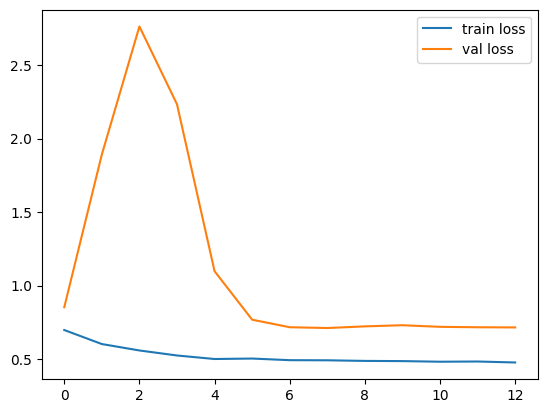

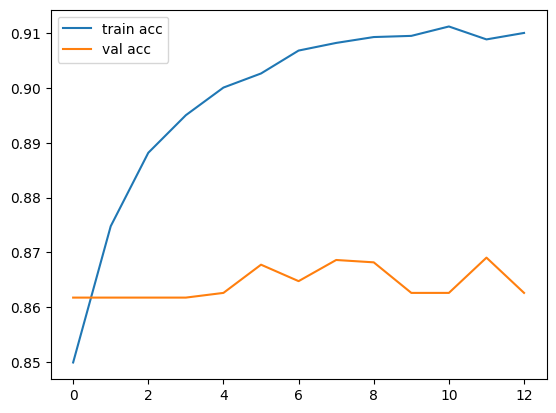

<Figure size 640x480 with 0 Axes>

In [94]:
# plot the loss
plt.plot(hist_simple_cnn.history['loss'], label='train loss')
plt.plot(hist_simple_cnn.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('Simple_cnn_LossVal_loss')

# plot the accuracy
plt.plot(hist_simple_cnn.history['accuracy'], label='train acc')
plt.plot(hist_simple_cnn.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('Simple_cnn_AccVal_acc')

Evaluating model_simple_cnn
44/44 [==============================] - 7s 166ms/step
Length of y_true: 2816
Length of y_pred: 2816
Precision: 0.7871198568872988
Recall: 0.9990917347865577
              precision    recall  f1-score   support

     Class 0       0.90      0.03      0.06       614
     Class 1       0.79      1.00      0.88      2202

    accuracy                           0.79      2816
   macro avg       0.85      0.52      0.47      2816
weighted avg       0.81      0.79      0.70      2816



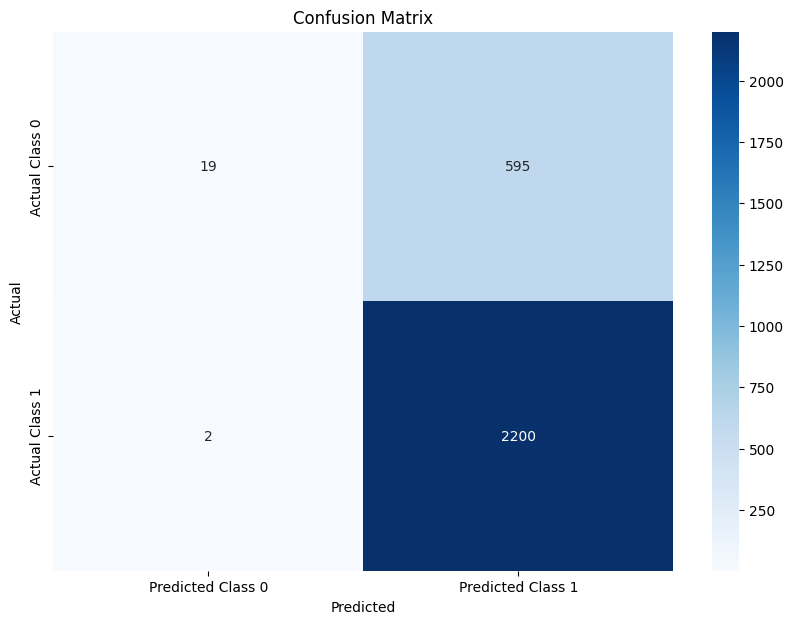

True Positives (TP): 2200
True Negatives (TN): 19
False Positives (FP): 595
False Negatives (FN): 2


In [95]:
# Evaluate Xception model
print("Evaluating model_simple_cnn")
evaluate_model(model_simple_cnn, test_generator)